<img src='img/logo.png' width='200px' style='float: right; margin-left: 20px'>

# Belarus 2020 presidential election "results"


The 2020 Belarusian presidential election was held on Sunday, 9 August 2020. Early voting began on 4 August and ran until 8 August. According to official results Alexander Lukashenko won with 80.10% of votes. Lots of violations were recorded on the polling stations. Independent election observers were not allowed to the precincts. At many precincts final protocols were not even published. Internet initiative "The Voice" collected photos of voters and official protocols, analized them and [published a report](http://bit.ly/golos-final-report) that shows results were falsified. They also [published official protocol results](https://bit.ly/golos_final_data) from some polling stations, that were photographed by people. 

Let's take a look at this data.

In [52]:
import pandas as pd
import googlemaps
import numpy as np
import requests
import folium
import matplotlib.pyplot as plt
from math import log10

gmaps = googlemaps.Client(key='***') # Google maps API key

## Reading excel file with protocol results

In [132]:
df = pd.read_excel('protocols.xlsx', usecols='A:AA')

## Getting coordinates with Google Maps API

I'm going to use Google Maps API to get coordinates of polling stations by address.

In [162]:
def get_location(address):
    geocode = gmaps.geocode(address)
    if geocode:
        return geocode[0]['geometry']['location']
    else:
        return None

In [166]:
df['location'] = df['Адрес'].apply(get_location)
new = df['location'].str.split(',')
df['location'].fillna(value=np.nan, inplace=True)
df = df.join(df['location'].apply(pd.Series).drop(0, axis=1))
df.drop('location', axis=1, inplace=True)

Some of the locations were not obtained by API. Let's fill them out manually.

In [ ]:
df.to_csv('vote.csv', index=False)
df = pd.read_csv('vote2.csv')

## Getting violations with Zubr.in API
The other internet iniative Zubr.in has violations messages from observers. Let's get and clean them.

In [258]:
def get_messages(qty):
    r = requests.get(f'https://busel.in/newsletter?count={qty}&page=1&searchBy=&search=&pagination=true&exists[approvedAt]=true&sort[createdAt]=desc')
    return pd.DataFrame(r.json()['hydra:member'])

In [261]:
mes = get_messages(7000)
mes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6798 entries, 0 to 97
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   @id             6798 non-null   object
 1   @type           6798 non-null   object
 2   id              6798 non-null   int64 
 3   attachments     6798 non-null   object
 4   categories      6798 non-null   object
 5   initiative      6798 non-null   int64 
 6   description     6798 non-null   object
 7   commissionCode  6798 non-null   object
 8   comment         6798 non-null   object
 9   createdAt       6798 non-null   object
 10  fromOutside     6798 non-null   bool  
 11  observerUid     5222 non-null   object
 12  messageId       6798 non-null   object
 13  commission      6665 non-null   object
 14  highlightedAt   174 non-null    object
dtypes: bool(1), int64(2), object(12)
memory usage: 803.3+ KB


In [288]:
mes.drop(['@id', '@type', 'attachments', 'commission', 'highlightedAt', 'messageId'], axis=1, inplace=True)
mes.set_index('id', inplace=True)
mes['createdAt'] = pd.to_datetime(mes['createdAt'])

Save messages to file.

In [302]:
mes.to_csv('messages.csv')

Counting number of reported violations on every polling station. 

In [313]:
mes['quantity'] = mes['categories'].apply(lambda x: len(x))
violations = mes.groupby('commissionCode')['quantity'].sum().to_frame()
violations.reset_index(inplace=True)
violations.rename(columns={'commissionCode': 'Код участка',
                  'quantity': 'Количество нарушений'}, inplace=True)



Merging all together.

In [376]:
report = pd.merge(df, violations, on='Код участка', how='left')

In [377]:
report.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1310 entries, 0 to 1309
Data columns (total 30 columns):
 #   Column                                                                                                                        Non-Null Count  Dtype  
---  ------                                                                                                                        --------------  -----  
 0   Область                                                                                                                       1310 non-null   object 
 1   Район                                                                                                                         1310 non-null   object 
 2   Нас. пункт                                                                                                                    1310 non-null   object 
 3   Адрес                                                                                                            

## Cleaning the data
Changing column names

In [381]:
report.rename({
    'Область': 'region',
    'Район': 'district',
    'Нас. пункт': 'city',
    'Код участка': 'precinct',
    '1. Агульная колькасць выбаршчыкаў': 'voters',
    '2. Колькасць выбаршчыкаў, якія атрымалі бюлетэнь': 'ballots',
    '3. Колькасць выбаршчыкаў, якія прынялі удзел у галасаванні': 'voted'
}, axis=1 ,inplace=True)

In [386]:
report.rename({
    report.columns[12]: 'preterm',
    report.columns[13]: 'atHome',
    report.columns[14]: 'electionDay',
    report.columns[15]: 'Dmitriev',
    report.columns[16]: 'Kanopackaya',
    report.columns[17]: 'Lukashenko',
    report.columns[18]: 'Tikhanovskaya',
    report.columns[19]: 'Cherechen',
    report.columns[21]: 'againstAll',
    report.columns[22]: 'invalidBallots',
    report.columns[23]: 'totalBallots',
    report.columns[24]: 'spoiledBallots',
    report.columns[25]: 'unusedBallots',
    report.columns[27]: 'noReport',
    report.columns[29]: 'violations'
}, axis=1, inplace=True)

Removing unnecessary columns.

In [389]:
report.drop([report.columns[3], report.columns[6], report.columns[8], report.columns[20], report.columns[26], 
             report.columns[28]], axis=1, inplace=True)
report.set_index('precinct', inplace=True)

## Feature engineering
Let's add columns for Tikhanovskaya and Lukashenko percentage and turnout on every station. Also let us add feature indicating is the polling station situated outside of Belarus.

In [402]:
report['TikhanovskayaPercentage'] = report['Tikhanovskaya']/report['voted']
report['LukashenkoPercentage'] = report['Lukashenko']/report['voted']
report['turnout'] = report['ballots']/report['voters']
report['outsideBelarus'] = report['district'] == 'Зарубежный'

## Maps

### Map of polling stations where Tikhanovskaya won*
*according to official protocols

In [445]:
t_won = report[report['TikhanovskayaPercentage'] > report['LukashenkoPercentage']]

fmap = folium.Map(
    location=[52.010322, 17.300925],
    zoom_start=4
)
t_won.apply(lambda row:folium.Marker(location=[row['lat'], 
                                                  row['lng']]).add_to(fmap),
         axis=1)
fmap

## Benford's law

>**Benford's law**, also called the **Newcomb–Benford law**, the **law of anomalous numbers**, or the **first-digit law**, is an observation about the frequency distribution of leading digits in many real-life sets of numerical data. The law states that in many naturally occurring collections of numbers, the leading digit is likely to be small. In sets that obey the law, the number 1 appears as the leading significant digit about 30% of the time, while 9 appears as the leading significant digit less than 5% of the time. If the digits were distributed uniformly, they would each occur about 11.1% of the time. Benford's law also makes predictions about the distribution of second digits, third digits, digit combinations, and so on.

In [54]:
def benford(n):
    return log10(n+1) - log10(n)

x = [i for i in range(1, 10)]
ben = pd.Series([benford(i) for i in x], index=range(1,10), name='Benford\'s law')

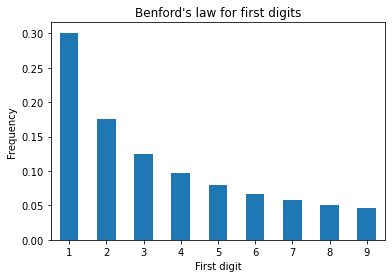

In [61]:
ben.plot.bar()
plt.title('Benford\'s law for first digits')
plt.xlabel('First digit')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [46]:
luk = df['Lukashenko'].apply(lambda x: int(str(x)[:1])).value_counts(normalize=True).sort_index()
tikh = df['Tikhanovskaya'].apply(lambda x: int(str(x)[:1])).value_counts(normalize=True).sort_index()

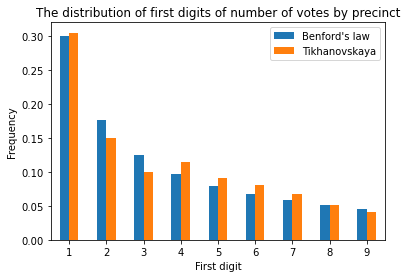

In [104]:
pd.concat([ben, tikh], axis=1).plot.bar()
plt.title('The distribution of first digits of number of votes by precinct')
plt.xlabel('First digit')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

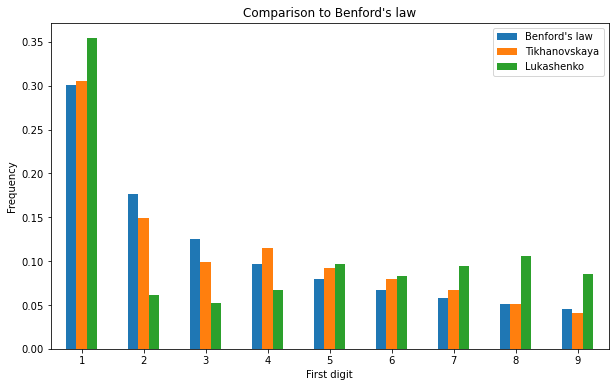

In [72]:
fig = pd.concat([ben, tikh, luk], axis=1).plot.bar(figsize=(10,6))
plt.title('Сomparison to Benford\'s law')
plt.xlabel('First digit')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [84]:
candidates = df.loc[:, 'Dmitriev':'Cherechen'].fillna(0)

In [101]:
digits = pd.Series(candidates.applymap(lambda x: int(str(x)[:1])).stack().value_counts(normalize=True).drop(0), name='Results')

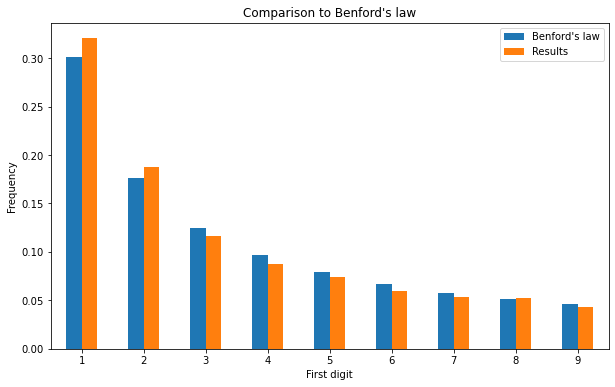

In [102]:
fig = pd.concat([ben, digits], axis=1).plot.bar(figsize=(10,6))
plt.title('Сomparison to Benford\'s law')
plt.xlabel('First digit')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()